In [1]:
from keras.layers import InputLayer, Flatten, Dense, Reshape, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Sequential
from keras.models import Model

Using TensorFlow backend.


In [2]:
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt

In [3]:
files = []
for r, d, f in os.walk('./emojies/'):
    for file in f:
            files.append(os.path.join(r, file))

dataset = np.zeros((len(files),72,72,4))
for i in range(0, len(files)):
    file = files[i]
    image = imageio.imread(file)
    if image.shape == (72,72,4):
        dataset[i] = image
print("Dataset shape is", dataset.shape)

Dataset shape is (2807, 72, 72, 4)


In [4]:
dataset = dataset.astype('float32') / 255

In [124]:
image_shape = (72,72,4)
encoding_dim = 1

In [125]:
def build_simple_autoencoder():
    encoder_input = Input(shape=image_shape)
    encoder_1 = Flatten()(encoder_input)
    encoder_2 = Dense(units=encoding_dim*3, activation="relu")(encoder_1)
    encoder_3 = Dense(units=encoding_dim*2, activation="relu")(encoder_2)
    encoder_4 = Dense(units=encoding_dim, activation="linear")(encoder_3)
    
    encoder = Model(encoder_input, encoder_4, name="encoder")

    decoder_input = Input(shape=(encoding_dim,))
    decoder_1 = Dense(units=encoding_dim*2, activation='relu')(decoder_input)
    decoder_2 = Dense(units=encoding_dim*3, activation='relu')(decoder_1)
    decoder_3 = Dense(units=72*72*4, activation='sigmoid')(decoder_2)
    decoder_4 = Reshape(target_shape=image_shape)(decoder_3)
    
    decoder = Model(decoder_input, decoder_4, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [126]:
def build_dens_autoencoder():
    
    encoder_input = Input(shape=image_shape, name='encoder_0')
    encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_1')(encoder_input)
    encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_2')(encoder_layer)
    encoder_layer = Dropout(0.25, name='encoder_3')(encoder_layer)
    encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_4')(encoder_layer)
    encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_5')(encoder_layer)
    encoder_layer = Dropout(0.25, name='encoder_6')(encoder_layer)
    encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_7')(encoder_layer)
    encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_8')(encoder_layer)
    encoder_layer = Dropout(0.25, name='encoder_9')(encoder_layer)
    encoder_layer = Flatten(name='encoder_10')(encoder_layer)
    encoder = Model(encoder_input, encoder_layer, name="encoder")

    decoder_input = Input(shape=(324,), name='decoder_0')
    decoder_layer = Reshape(target_shape=(9,9,4), name='decoder_1')(decoder_input)
    decoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='decoder_3')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2), name='decoder_4')(decoder_layer)
    decoder_layer = Dropout(0.25, name='decoder_5')(decoder_layer)
    decoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='decoder_6')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2), name='decoder_7')(decoder_layer)
    decoder_layer = Dropout(0.25, name='decoder_8')(decoder_layer)
    decoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='decoder_9')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2), name='decoder_10')(decoder_layer)
    decoder_layer = Dropout(0.25, name='decoder_11')(decoder_layer)
    decoder = Model(decoder_input, decoder_layer, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return encoder, decoder, autoencoder

In [127]:
encoder, decoder, autoencoder = build_simple_autoencoder()
# encoder, decoder, autoencoder = build_dens_autoencoder()

In [128]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 72, 72, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 62211     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 62,222
Trainable params: 62,222
Non-trainable params: 0
_________________________________________________________________


In [129]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_12 (Dense)             (None, 20736)             82944     
_________________________________________________________________
reshape_2 (Reshape)          (None, 72, 72, 4)         0         
Total params: 82,957
Trainable params: 82,957
Non-trainable params: 0
_________________________________________________________________


In [130]:
autoencoder.fit(dataset, dataset,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(dataset, dataset))

Train on 2807 samples, validate on 2807 samples
Epoch 1/20
2807/2807 [==============================] - 4s 1ms/step - loss: 0.6918 - val_loss: 0.6882
Epoch 2/20
2807/2807 [==============================] - 3s 966us/step - loss: 0.6769 - val_loss: 0.6562
Epoch 3/20
2807/2807 [==============================] - 3s 905us/step - loss: 0.6314 - val_loss: 0.6035
Epoch 4/20
2807/2807 [==============================] - 3s 902us/step - loss: 0.5920 - val_loss: 0.5806
Epoch 5/20
2807/2807 [==============================] - 2s 888us/step - loss: 0.5755 - val_loss: 0.5706
Epoch 6/20
2807/2807 [==============================] - 3s 935us/step - loss: 0.5678 - val_loss: 0.5644
Epoch 7/20
2807/2807 [==============================] - 3s 922us/step - loss: 0.5621 - val_loss: 0.5593
Epoch 8/20
2807/2807 [==============================] - 3s 1ms/step - loss: 0.5572 - val_loss: 0.5543
Epoch 9/20
2807/2807 [==============================] - 3s 1ms/step - loss: 0.5521 - val_loss: 0.5493
Epoch 10/20
2807/2807 

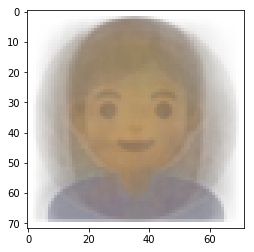

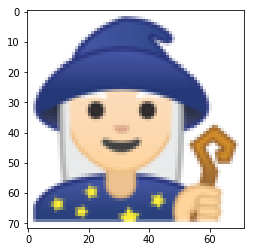

In [132]:
i = 111
imgs = dataset[i:i+1]
predicted_imgs = autoencoder.predict(imgs, batch_size=1)
for ind in range(0,len(imgs)):
    plt.imshow(predicted_imgs[ind])
    plt.show()
    plt.imshow(imgs[ind])
    plt.show()

In [133]:
imgs = dataset[2:3]
encoded_imgs = encoder.predict(imgs)
for encoded_img in encoded_imgs:
    print(encoded_img.shape)
    print(encoded_img)
#     print(encoded_img)
#     plt.imshow(encoded_img)
#     plt.show()

(1,)
[67.81933]


(72, 72, 4)


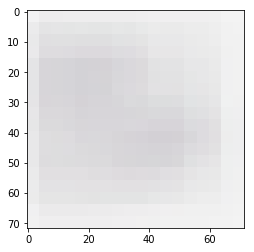

In [96]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=1)
for decoded_img in decoded_imgs:
    print(decoded_img.shape)
    plt.imshow(decoded_img)
    plt.show()

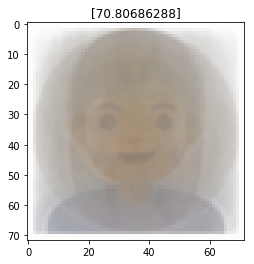

In [164]:
seeds = np.random.uniform(low=0.0, high=100.0, size=(1,))
# seeds = np.random.normal(loc=1.0, scale=10.0, size=(1,18,18,1))
# seeds = np.random.beta(a=0.6, b=1.2, size=(1,encoding_dim))
generated_imgs = decoder.predict(seeds, batch_size=1)
for generated_img in generated_imgs:
    plt.imshow(generated_img)
#     print(generated_img)
    plt.title(str(seeds))
    plt.show()

In [108]:
encoder_input = Input(shape=image_shape, name='encoder_0')

encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_1')(encoder_input)
encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_2')(encoder_layer)
encoder_layer = Dropout(0.25, name='encoder_3')(encoder_layer)

encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_4')(encoder_layer)
encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_5')(encoder_layer)
encoder_layer = Dropout(0.25, name='encoder_6')(encoder_layer)

encoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='encoder_7')(encoder_layer)
encoder_layer = MaxPooling2D((2, 2), padding='same', name='encoder_8')(encoder_layer)
encoder_layer = Dropout(0.25, name='encoder_9')(encoder_layer)

encoder_layer = Flatten(name='encoder_10')(encoder_layer)

encoder = Model(encoder_input, encoder_layer, name="encoder")

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_0 (InputLayer)       (None, 72, 72, 4)         0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 72, 72, 4)         68        
_________________________________________________________________
encoder_2 (MaxPooling2D)     (None, 36, 36, 4)         0         
_________________________________________________________________
encoder_3 (Dropout)          (None, 36, 36, 4)         0         
_________________________________________________________________
encoder_4 (Conv2D)           (None, 36, 36, 4)         68        
_________________________________________________________________
encoder_5 (MaxPooling2D)     (None, 18, 18, 4)         0         
_________________________________________________________________
encoder_6 (Dropout)          (None, 18, 18, 4)         0         
__________

In [88]:
decoder_input = Input(shape=(36,), name='decoder_0')

decoder_layer = Reshape(target_shape=(3,3,4), name='decoder_1')(decoder_input)

decoder_layer = Conv2D(4, (2, 2), activation='relu', padding='same', name='decoder_3')(decoder_layer)
decoder_layer = UpSampling2D((2, 2), name='decoder_4')(decoder_layer)
decoder_layer = Dropout(0.25, name='decoder_5')(decoder_layer)

decoder_layer = Conv2D(4, (3, 3), activation='relu', padding='same', name='decoder_6')(decoder_layer)
decoder_layer = UpSampling2D((3, 3), name='decoder_7')(decoder_layer)
decoder_layer = Dropout(0.25, name='decoder_8')(decoder_layer)

decoder_layer = Conv2D(4, (4, 4), activation='relu', padding='same', name='decoder_9')(decoder_layer)
decoder_layer = UpSampling2D((4, 4), name='decoder_10')(decoder_layer)
decoder_layer = Dropout(0.25, name='decoder_11')(decoder_layer)

decoder = Model(decoder_input, decoder_layer, name="decoder")

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_0 (InputLayer)       (None, 36)                0         
_________________________________________________________________
decoder_1 (Reshape)          (None, 3, 3, 4)           0         
_________________________________________________________________
decoder_3 (Conv2D)           (None, 3, 3, 4)           68        
_________________________________________________________________
decoder_4 (UpSampling2D)     (None, 6, 6, 4)           0         
_________________________________________________________________
decoder_5 (Dropout)          (None, 6, 6, 4)           0         
_________________________________________________________________
decoder_6 (Conv2D)           (None, 6, 6, 4)           148       
_________________________________________________________________
decoder_7 (UpSampling2D)     (None, 18, 18, 4)         0         
__________